In [1]:
import tensorflow as tf
from tensorflow.keras import Model, layers, models
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [2]:
image_size=(176,224)
batch_size=16
ds_path="C:/geetesh/aimldl/projects/denoiser/128xSkip/dataset"

In [3]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=ds_path,
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    seed=42,
    subset="training",
    label_mode=None
)

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
    directory=ds_path,
    image_size=image_size,
    batch_size=batch_size,
    validation_split=0.2,
    seed=42,
    subset="validation",
    label_mode=None
)


Found 202599 files belonging to 1 classes.
Using 162080 files for training.
Found 202599 files belonging to 1 classes.
Using 40519 files for validation.


In [4]:
def rgb_to_lab_tf(rgb):
    """
    rgb: (B,H,W,3) in [0,1]
    returns:
      L  : (B,H,W,1) in [0,1]
      ab : (B,H,W,2) in [-1,1]
    """

    # sRGB → linear RGB
    def inv_gamma(u):
        return tf.where(
            u <= 0.04045,
            u / 12.92,
            tf.pow((u + 0.055) / 1.055, 2.4)
        )

    rgb = inv_gamma(rgb)

    # RGB → XYZ
    r, g, b = rgb[...,0], rgb[...,1], rgb[...,2]

    x = 0.412453*r + 0.357580*g + 0.180423*b
    y = 0.212671*r + 0.715160*g + 0.072169*b
    z = 0.019334*r + 0.119193*g + 0.950227*b

    # Normalize for D65
    x /= 0.95047
    z /= 1.08883

    # XYZ → LAB
    delta = 6/29

    def f(t):
        return tf.where(
            t > delta**3,
            tf.pow(t, 1/3),
            t/(3*delta**2) + 4/29
        )

    fx, fy, fz = f(x), f(y), f(z)

    L = 116*fy - 16
    a = 500*(fx - fy)
    b = 200*(fy - fz)

    # Normalize
    L = L / 100.0
    a = a / 128.0
    b = b / 128.0

    L = tf.expand_dims(L, -1)
    ab = tf.stack([a, b], axis=-1)

    return L, ab


In [5]:
def preprocess(rgb):
    rgb = tf.cast(rgb, tf.float32) / 255.0
    return rgb_to_lab_tf(rgb)

In [6]:
train_ds = (
    raw_train_ds
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

val_ds = (
    raw_val_ds
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)


In [7]:
def lab_to_rgb_tf(L, ab):
    L = tf.clip_by_value(L, 0.0, 1.0)
    ab = tf.clip_by_value(ab, -1.0, 1.0)
    L = L * 100.0
    a = ab[..., 0:1] * 128.0
    b = ab[..., 1:2] * 128.0

    fy = (L + 16.0) / 116.0
    fx = fy + a / 500.0
    fz = fy - b / 200.0

    delta = 6 / 29

    def f_inv(t):
        return tf.where(
            t > delta,
            t**3,
            3 * delta**2 * (t - 4/29)
        )

    x = 0.95047 * f_inv(fx)
    y = f_inv(fy)
    z = 1.08883 * f_inv(fz)

    r =  3.2406*x - 1.5372*y - 0.4986*z
    g = -0.9689*x + 1.8758*y + 0.0415*z
    b =  0.0557*x - 0.2040*y + 1.0570*z

    # 🔥 FIX HERE
    rgb = tf.concat([r, g, b], axis=-1)

    return tf.clip_by_value(rgb, 0.0, 1.0)


In [ ]:
class Colorizer_AutoEncoder(tf.keras.Model):
    def __init__(self):
        super().__init__()

        # -------- Encoder --------
        self.e1 = layers.Conv2D(64, 2, strides=2, padding='same', activation='relu')
        self.e2 = layers.Conv2D(128, 2, strides=2, padding='same', activation='relu')
        self.e3 = layers.Conv2D(256, 2, strides=2, padding='same', activation='relu')
        self.e4 = layers.Conv2D(512, 2, strides=2, padding='same', activation='relu')

        # -------- Bottleneck --------
        self.b1 = layers.Conv2D(512, 2, padding='same', activation='relu')
        self.b2 = layers.Conv2D(512, 2, padding='same', activation='relu')

        # -------- Decoder --------
        self.d0 = layers.Conv2D(512, 2, padding='same', activation='relu')
        self.u0 = layers.UpSampling2D(2)
        self.r0 = layers.Conv2D(512, 1, activation='relu')

        self.d1 = layers.Conv2D(256, 2, padding='same', activation='relu')
        self.u1 = layers.UpSampling2D(2)
        self.r1 = layers.Conv2D(256, 1, activation='relu')

        self.d2 = layers.Conv2D(128, 2, padding='same', activation='relu')
        self.u2 = layers.UpSampling2D(2)
        self.r2 = layers.Conv2D(128, 1, activation='relu')

        self.d3 = layers.Conv2D(64, 2, padding='same', activation='relu')
        self.u3 = layers.UpSampling2D(2)
        self.r3 = layers.Conv2D(64, 1, activation='relu')

        # -------- Output (ab channels) --------
        self.out = layers.Conv2D(2, 1, activation='tanh')

    # -------- Forward pass --------
    def call(self, L):
        e1 = self.e1(L)
        e2 = self.e2(e1)
        e3 = self.e3(e2)
        e4 = self.e4(e3)

        x = self.b1(e4)
        x = self.b2(x)

        x = self.d0(x)
        x = self.r0(tf.concat([x, e4], axis=-1))
        x = self.u0(x)

        x = self.d1(x)
        x = self.r1(tf.concat([x, e3], axis=-1))
        x = self.u1(x)

        x = self.d2(x)
        x = self.r2(tf.concat([x, e2], axis=-1))
        x = self.u2(x)

        x = self.d3(x)
        x = self.r3(tf.concat([x, e1], axis=-1))
        x = self.u3(x)

        return self.out(x)

   
    def train_step(self, data):
        L, ab_true = data

        with tf.GradientTape() as tape:
            ab_pred = self(L, training=True)
            ab_pred = tf.clip_by_value(ab_pred, -1.0, 1.0)

            mae = tf.reduce_mean(tf.abs(ab_true - ab_pred))

            rgb_true = lab_to_rgb_tf(L, ab_true)
            rgb_pred = lab_to_rgb_tf(L, ab_pred)

            rgb_true = tf.clip_by_value(rgb_true, 0.0, 1.0)
            rgb_pred = tf.clip_by_value(rgb_pred, 0.0, 1.0)

            ssim = tf.image.ssim(rgb_true, rgb_pred, max_val=1.0)
            ssim_loss = 1.0 - tf.reduce_mean(ssim)

            loss = mae + 0.2 * ssim_loss

            tf.debugging.check_numerics(loss, "LOSS CONTAINS NaN")

        grads = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {
            "loss": loss,
            "mae": mae,
            "ssim_loss": ssim_loss
        }

    def test_step(self, data):
        L, ab_true = data

        ab_pred = self(L, training=False)
        ab_pred = tf.clip_by_value(ab_pred, -1.0, 1.0)

        mae = tf.reduce_mean(tf.abs(ab_true - ab_pred))

        rgb_true = lab_to_rgb_tf(L, ab_true)
        rgb_pred = lab_to_rgb_tf(L, ab_pred)

        rgb_true = tf.clip_by_value(rgb_true, 0.0, 1.0)
        rgb_pred = tf.clip_by_value(rgb_pred, 0.0, 1.0)

        ssim = tf.image.ssim(rgb_true, rgb_pred, max_val=1.0)
        ssim_loss = 1.0 - tf.reduce_mean(ssim)

        loss = mae + 0.2 * ssim_loss

        return {
            "loss": loss,
            "mae": mae,
            "ssim_loss": ssim_loss
        }




In [9]:
model = Colorizer_AutoEncoder()
model.build((None, 176, 224, 1))
model.load_weights("Colorizer/variables/variables")



In [10]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(5e-5)
)


In [14]:
model.fit(train_ds,validation_data=val_ds,epochs=5)

Epoch 1/5
10130/10130 [==============================] - 1702s 168ms/step - loss: 0.0626 - mae: 0.0504 - ssim_loss: 0.0611 - val_loss: 0.0503 - val_mae: 0.0406 - val_ssim_loss: 0.0483
Epoch 2/5
10130/10130 [==============================] - 1697s 168ms/step - loss: 0.0621 - mae: 0.0500 - ssim_loss: 0.0604 - val_loss: 0.0424 - val_mae: 0.0356 - val_ssim_loss: 0.0340
Epoch 3/5
10130/10130 [==============================] - 1717s 169ms/step - loss: 0.0617 - mae: 0.0497 - ssim_loss: 0.0599 - val_loss: 0.0747 - val_mae: 0.0589 - val_ssim_loss: 0.0788
Epoch 4/5
  629/10130 [>.............................] - ETA: 23:02 - loss: 0.0609 - mae: 0.0491 - ssim_loss: 0.0591

KeyboardInterrupt: 

In [15]:
model.save("0.2colouizer")

INFO:tensorflow:Assets written to: 0.2colouizer\assets


INFO:tensorflow:Assets written to: 0.2colouizer\assets


In [27]:
model = Colorizer_AutoEncoder()
model.build((None, 176, 224, 1))
model.load_weights("0.2colouizer/variables/variables")



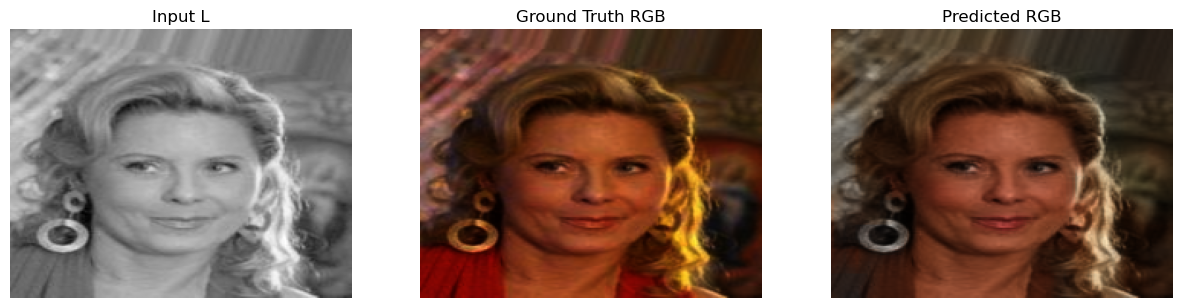

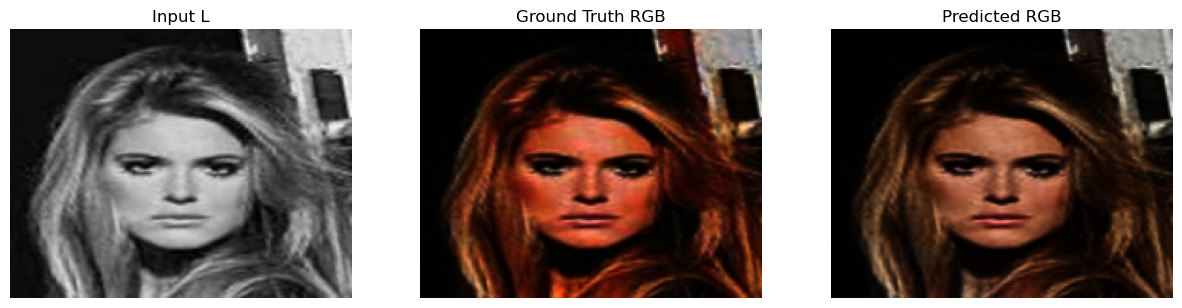

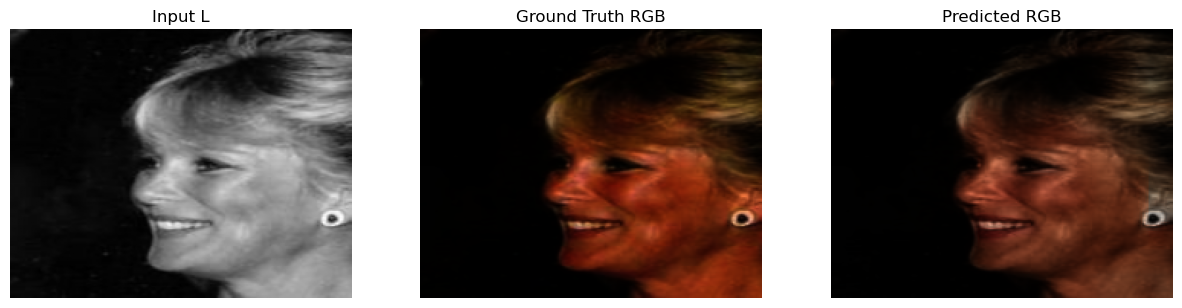

In [29]:
L_batch, ab_batch = next(iter(val_ds))

for idx in range(3):   # visualize first 3 images
    L = L_batch[idx:idx+1]
    ab_true = ab_batch[idx:idx+1]

    ab_pred = model(L, training=False)

    rgb_true = lab_to_rgb_tf(L, ab_true)
    rgb_pred = lab_to_rgb_tf(L, ab_pred)

    plt.figure(figsize=(15,5))

    plt.subplot(1,3,1)
    plt.title("Input L")
    plt.imshow(L[0,...,0], cmap="gray")
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Ground Truth RGB")
    plt.imshow(rgb_true[0])
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Predicted RGB")
    plt.imshow(rgb_pred[0])
    plt.axis("off")

    plt.show()

